In [1]:
''' For each saildrone, scan through the tracks and record the TC impact period for bandpassing the ocean current velocities. 
Goal:   output the time range when SD is under TC impact by wind speed > a specific criteria. 
        for each t/x/y of SD records, determine the quadrant relatvie to the storm. 
Note: interpolate TC tracks to SD timestamp using Makima interpolation method '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import math
from scipy.interpolate import Akima1DInterpolator
from importlib.metadata import version
print(version('scipy'))
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from compute_distance import distance
from windstr import wind_adj2height_PL

1.10.0


In [2]:
year = '2023'
''' Filter the SD filenames that will be scanned for TC impacts '''
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/' # 1-min data
fns_SD_all = np.sort( os.listdir(path_airsea) )
fns_SD = []
for fn in fns_SD_all:
    if ('airsea-raw-merge' in fn) & (year in fn):
        fns_SD.append(fn)
print('SD filenames that will be looked at:',fns_SD)

''' TC track files '''
path_TCs = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/data_TC-tracks/'
fns_TCs_all = np.sort( os.listdir(path_TCs) )
fns_TCs = []
for fn in fns_TCs_all:
    if (year+'.txt' in fn):
        fns_TCs.append(fn)
print('TC track file names that will be look at:',fns_TCs)

''' read TC track file '''
TCnames = np.genfromtxt(path_TCs+fns_TCs[0], delimiter=' ', skip_header=2, usecols=(0,), dtype=str)
dataTC = np.genfromtxt(path_TCs+fns_TCs[0], delimiter=' ',skip_header=2, usecols=(1,2,3,4,15,16), dtype=float)

SD filenames that will be looked at: ['airsea-raw-merge-2023-SD1031.nc', 'airsea-raw-merge-2023-SD1036.nc', 'airsea-raw-merge-2023-SD1040.nc', 'airsea-raw-merge-2023-SD1041.nc', 'airsea-raw-merge-2023-SD1042.nc', 'airsea-raw-merge-2023-SD1045.nc', 'airsea-raw-merge-2023-SD1057.nc', 'airsea-raw-merge-2023-SD1064.nc', 'airsea-raw-merge-2023-SD1065.nc', 'airsea-raw-merge-2023-SD1068.nc', 'airsea-raw-merge-2023-SD1069.nc', 'airsea-raw-merge-2023-SD1083.nc']
TC track file names that will be look at: ['timeseries_IBTrACS_NA_2023.txt']


(array([215., 348.,  37., 152., 521., 143.,  47.,  39.,  18.,   3.]),
 array([-4. , -3.1, -2.2, -1.3, -0.4,  0.5,  1.4,  2.3,  3.2,  4.1,  5. ]),
 <BarContainer object of 10 artists>)

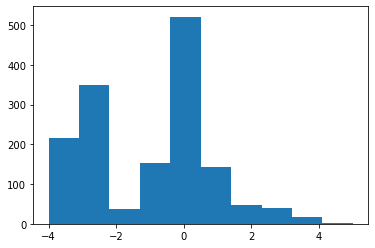

In [3]:
plt.hist(dataTC[:,3])

[ 1.6737696e+09 -7.1300000e+01  3.6400000e+01 -4.0000000e+00
  7.0000000e+00  5.5000000e+01]
['ARLENE' 'BRET' 'CINDY' 'DON' 'EMILY' 'FRANKLIN' 'GERT' 'HAROLD' 'IDALIA'
 'JOSE' 'KATIA' 'LEE' 'MARGOT' 'NIGEL' 'OPHELIA' 'PHILIPPE' 'RINA' 'SEAN'
 'TAMMY' 'UNNAMED']
ARLENE (5041, 7)
BRET (12602, 7)
CINDY (18363, 7)
DON (38884, 7)
EMILY (48605, 7)
FRANKLIN (78846, 7)
GERT (102607, 7)
HAROLD (105488, 7)
IDALIA (123849, 7)
JOSE (129250, 7)
KATIA (153011, 7)
LEE (172092, 7)
MARGOT (188293, 7)
NIGEL (204494, 7)
OPHELIA (209175, 7)
PHILIPPE (227896, 7)
RINA (233297, 7)
SEAN (241938, 7)
TAMMY (260659, 7)
UNNAMED (702740, 7)


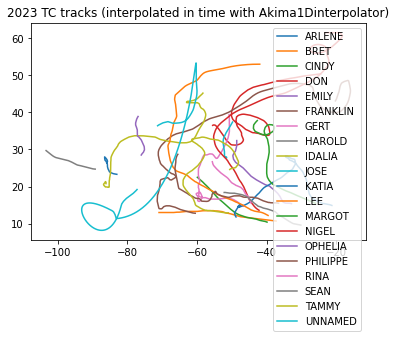

In [4]:
print(dataTC[0])
TCnames_uniq = np.unique( TCnames )
print(TCnames_uniq)
dataTC_intp = np.empty( (0,7) )
plt.clf()
''' interpolate TC tracks to 1-min intervals '''
for TCnm in TCnames_uniq:
    irow_TCnm = np.where(TCnames == TCnm)[0]
    timestampbt_TCnm = dataTC[irow_TCnm,0]
    lonbt_TCnm = dataTC[irow_TCnm,1]
    latbt_TCnm = dataTC[irow_TCnm,2]
    databt_TCnm = dataTC[irow_TCnm,3:]
    timestampbt_intp = np.arange(round(timestampbt_TCnm[0]),round(timestampbt_TCnm[-1])+60,60)
    lonbt_intp = Akima1DInterpolator(timestampbt_TCnm, lonbt_TCnm)(timestampbt_intp)
    latbt_intp = Akima1DInterpolator(timestampbt_TCnm, latbt_TCnm)(timestampbt_intp)
    data_intp = np.nan*np.ones( (len(timestampbt_intp),3) )
    ''' Not interpolate sshs, storm speed, storm direction for simplicity '''
    for i, ts in enumerate(timestampbt_intp):
        imin = np.argmin( np.abs(timestampbt_TCnm-ts) )
        data_intp[i,:] = databt_TCnm[imin,:]
    plt.plot(lonbt_intp, latbt_intp, label=TCnm)
    append_intp = np.column_stack( (np.array([TCnm]*len(timestampbt_intp)),timestampbt_intp, lonbt_intp, latbt_intp, data_intp))
    dataTC_intp = np.vstack( (dataTC_intp,append_intp) )
    print(TCnm, dataTC_intp.shape)
    # break
plt.legend()
plt.title(year+' TC tracks (interpolated in time with Akima1Dinterpolator)')
plt.savefig('map_TC-track_names_'+year+'.png',dpi=400,bbox_inches='tight')

In [5]:
for item in dataTC_intp[0]:
    print(item, type(item))

ARLENE <class 'numpy.str_'>
1685581200 <class 'numpy.str_'>
nan <class 'numpy.str_'>
nan <class 'numpy.str_'>
-3.0 <class 'numpy.str_'>
3.0 <class 'numpy.str_'>
40.0 <class 'numpy.str_'>


In [7]:
vars_SD_str = ['time','latitude','longitude','UWND_MEAN','VWND_MEAN']#,'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
dsec_max_2bt = 1.5*60*60 # seconds
dist_max_2bt = 500 # km
data_out = np.empty( (0,8+len(dataTC[0])) )
timestampbt_intp = np.array([float(item) for item in dataTC_intp[:,1]])
''' Scan through SD file names & record TC intercepts '''
for f, fn_SD in enumerate( fns_SD ):
    year = fn_SD[-14:-10]
    SDnum = fn_SD[-7:-3]
    ds = nc.Dataset( path_airsea + fn_SD )
    print('Read:',fn_SD)
    for var_str in vars_SD_str:
        str_exec = var_str + '= ds.variables["'+var_str+'"][:]'
        exec(str_exec)
    ''' compute/ convert SD values '''
    timestamp_SD = np.array([(datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=round(item))).timestamp() for item in time])
    wdsp_SD = np.sqrt( np.square(UWND_MEAN) + np.square(VWND_MEAN) )
    wdsp10m_SD = wind_adj2height_PL(wdsp_SD, 3.5, 10)
    ''' search through two arrays (dataTC_interp vs. SD) & find matching indices for each TC '''
    for TCnm in TCnames_uniq:
        irow_TCnm = np.where(dataTC_intp[:,0] == TCnm)[0]
        timestampbt_TCnm = np.array([float(item) for item in dataTC_intp[irow_TCnm,1]])
        timestamp_ints, iTC, iSD = np.intersect1d( timestampbt_TCnm, timestamp_SD, assume_unique= True, return_indices=True )
        if len(timestamp_ints) > 0:
            # print(TCnm, irow_TCnm.shape, datetime.datetime.fromtimestamp(timestampbt_TCnm[0]),datetime.datetime.fromtimestamp(timestampbt_TCnm[-1]))
            # print('intersect time length:',timestamp_ints.shape, datetime.datetime.fromtimestamp(timestamp_ints[0]), datetime.datetime.fromtimestamp(timestamp_ints[-1]))
            latSD_ints = latitude[iSD]
            lonSD_ints = longitude[iSD]
            latTC_ints = dataTC_intp[irow_TCnm[iTC],3]
            lonTC_ints = dataTC_intp[irow_TCnm[iTC],2]
            dist2bt = np.array([distance(latSD_ints[i],lonSD_ints[i],float(latTC_ints[i]),float(lonTC_ints[i])) for i in range( len(timestamp_ints) )])
            in_dist = dist2bt< dist_max_2bt
            if np.sum(in_dist) > 0:
                SD_out = np.stack( (np.array([SDnum]*np.sum(in_dist)),timestamp_ints[in_dist],lonSD_ints[in_dist],latSD_ints[in_dist],\
                                    UWND_MEAN[iSD][in_dist],VWND_MEAN[iSD][in_dist],dist2bt[in_dist]),axis=1 )
                track_out = dataTC_intp[irow_TCnm[iTC][in_dist],:]
                combine_out = np.hstack( (SD_out, track_out) )
                data_out = np.vstack( (data_out, combine_out) )
                print(year,SDnum,data_out.shape,TCnm)
            else:
                print(year,SDnum,'has no data within {:.0f}km to '.format(dist_max_2bt)+TCnm)
        else:
            print(year,SDnum,'has no overlap times to',TCnm)
    ds.close()
    # break

Read: airsea-raw-merge-2023-SD1031.nc
2023 1031 has no overlap times to ARLENE
2023 1031 has no overlap times to BRET
2023 1031 has no overlap times to CINDY
2023 1031 has no overlap times to DON
2023 1031 has no data within 500km to EMILY
2023 1031 (3894, 14) FRANKLIN
2023 1031 has no data within 500km to GERT
2023 1031 has no data within 500km to HAROLD
2023 1031 has no data within 500km to IDALIA
2023 1031 has no data within 500km to JOSE
2023 1031 has no data within 500km to KATIA
2023 1031 has no data within 500km to LEE
2023 1031 has no data within 500km to MARGOT
2023 1031 has no data within 500km to NIGEL
2023 1031 has no data within 500km to OPHELIA
2023 1031 (6082, 14) PHILIPPE
2023 1031 has no data within 500km to RINA
2023 1031 has no data within 500km to SEAN
2023 1031 (9194, 14) TAMMY
2023 1031 (22941, 14) UNNAMED
Read: airsea-raw-merge-2023-SD1036.nc
2023 1036 has no overlap times to ARLENE
2023 1036 has no overlap times to BRET
2023 1036 has no overlap times to CINDY
20

In [8]:
for item in data_out[0]:
    print(item, type(item))

1031 <class 'numpy.str_'>
1692522780.0 <class 'numpy.str_'>
-66.7296448 <class 'numpy.str_'>
15.4633264 <class 'numpy.str_'>
-8.09 <class 'numpy.str_'>
-5.94 <class 'numpy.str_'>
499.92131996868454 <class 'numpy.str_'>
FRANKLIN <class 'numpy.str_'>
1692522780 <class 'numpy.str_'>
-62.69111110814412 <class 'numpy.str_'>
13.247777777036033 <class 'numpy.str_'>
-3.0 <class 'numpy.str_'>
16.0 <class 'numpy.str_'>
285.0 <class 'numpy.str_'>


In [9]:
''' From each row of data_out, determine the quadrant of SD relative to TC's '''
print('shape of the data_out',data_out.shape)
TCnames = np.unique( data_out[:,7])
for TCname in TCnames:
    irow_this_TC = np.where( data_out[:,7]== TCname)[0]
    SDs_this_TC = np.unique( data_out[irow_this_TC,0] )
    print(TCname,'is intercepted by:',SDs_this_TC)
    for SD_this_TC in SDs_this_TC:
        irowSD = np.where( data_out[irow_this_TC,0]== SD_this_TC )[0]
        timeSD = np.array([ float(item) for item in data_out[irow_this_TC,1][irowSD] ])
        dist2bt = np.array([ float(item) for item in data_out[irow_this_TC,6][irowSD] ])
        t1 = np.min( timeSD )
        t2 = np.max( timeSD )
        print( SD_this_TC,datetime.datetime.fromtimestamp(t1),'-',datetime.datetime.fromtimestamp(t2),\
              'min dist= {:.1f}km'.format(np.min(dist2bt)) )

shape of the data_out (151337, 14)
FRANKLIN is intercepted by: ['1031' '1036' '1040' '1057' '1064' '1065' '1068']
1031 2023-08-20 02:13:00 - 2023-08-22 19:06:00 min dist= 114.8km
1036 2023-08-24 15:42:00 - 2023-08-28 18:47:00 min dist= 175.7km
1040 2023-08-19 18:05:00 - 2023-08-20 09:36:00 min dist= 123.8km
1057 2023-08-29 02:03:00 - 2023-08-29 23:43:00 min dist= 441.8km
1064 2023-08-24 13:09:00 - 2023-08-27 20:55:00 min dist= 38.7km
1065 2023-08-27 17:12:00 - 2023-08-30 03:21:00 min dist= 454.3km
1068 2023-08-23 09:20:00 - 2023-08-26 14:33:00 min dist= 312.4km
GERT is intercepted by: ['1040' '1069']
1040 2023-08-21 10:36:00 - 2023-08-24 23:59:00 min dist= 313.3km
1069 2023-08-19 18:32:00 - 2023-08-21 21:40:00 min dist= 234.6km
HAROLD is intercepted by: ['1083']
1083 2023-08-21 12:01:00 - 2023-08-21 12:58:00 min dist= 477.1km
IDALIA is intercepted by: ['1045' '1057' '1065' '1083']
1045 2023-08-30 10:37:00 - 2023-08-31 19:11:00 min dist= 120.0km
1057 2023-08-31 03:03:00 - 2023-09-01 11:

In [10]:
''' Determine the quadrant where SD is relative to TC '''
quad2TC = np.nan*np.ones( (data_out.shape[0],) )
deg_TCdir2SD = quad2TC.copy()
isplot = False
for i, data in enumerate( data_out ):
    # print(data)
    if isplot:
        plt.plot(float(data[9]),float(data[10]),'<',ms=10,label='storm center')
        ''' plot axes according to storm direction '''
        dx = np.sin(float(data[13])/180*np.pi)
        dy = np.cos(float(data[13])/180*np.pi)
        slope = dy/dx
        intercept = float(data[10])-slope*float(data[9])
        x = float(data[9])+np.array([-1,0,1])
        y = slope*x+intercept
        plt.plot(x,y,'-',label='storm dir axis')
        slope = -slope
        intercept = float(data[10])-slope*float(data[9])
        y = slope*x+intercept
        plt.plot(x,y,'-')
        ''' plot SD location '''
        plt.plot(float(data[2]),float(data[3]),'o',ms=10,label='SD location')
        ''' figure settings '''
        plt.grid()
        plt.legend()
    ''' determine SD quadrant relative to storm direction '''
    dy = float(data[3])-float(data[10])
    dx = float(data[2])-float(data[9])
    dirSD = (90-math.degrees( math.atan2( dy,dx ) ))%360 # degree east of north
    # print(dy,dx, dirSD)
    deg_TCdir2SD[i] = (dirSD-float(data[13]))%360
    if (deg_TCdir2SD[i]> 0) & (deg_TCdir2SD[i]< 90):
        quad2TC[i] = 1
    elif (deg_TCdir2SD[i]> 90) & (deg_TCdir2SD[i]< 180):
        quad2TC[i] = 4
    elif (deg_TCdir2SD[i]> 180) & (deg_TCdir2SD[i]< 270):
        quad2TC[i] = 3
    elif (deg_TCdir2SD[i]> 270) & (deg_TCdir2SD[i]< 360):
        quad2TC[i] = 2
    else:
        quad2TC[i] = deg_TCdir2SD[i]
    # print('Degree (positive clockwise) rot. from TCdir to SD:',deg_TCdir2SD%360,quad2TC[i],'quadrant')
    # if i == 3:
    #     break

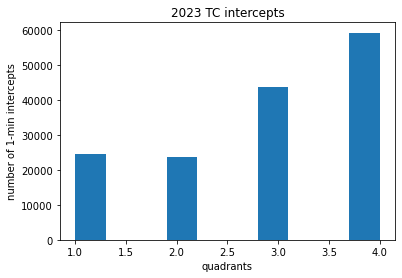

In [11]:
# plt.plot(deg_TCdir2SD)
# plt.plot(quad2TC,'.')
plt.hist(quad2TC)
plt.xlabel('quadrants')
plt.ylabel('number of 1-min intercepts')
plt.title(year+' TC intercepts')
plt.savefig('hist_quadrants-SD_TC-intercepts_lt{:.0f}km_'.format(dist_max_2bt)+year+'.png',dpi=400,bbox_inches='tight')

In [12]:
''' append degree from storm direction to SD location (positive clockwise) to data_out '''
data_out = np.column_stack( (data_out, quad2TC) )

''' write data_out to file '''
vars_str_out = ['SDnum','timestamp_SD','lonSD','latSD','UWND_MEAN(3.5m)','VWND_MEAN(3.5m)','dist2bt',\
                'TCname','timestamp_TC','usa_lonTC','usa_latTC','usa_sshs',\
                    'storm_speed','storm_dir','SDquadrant_2storm_dir']
units_str_out = ['(SD number)','(seconds since epoch)','(degE)','(degN)','(m/s)','(m/s)','(dist. to best track in km)',\
                 '(name)','(seconds since epoch)','(degE)','(degN)','()',\
                    '(kts)','(degrees)','(1~4 or cw in degreees)']
print('numbers of variable names & units to ouput:',len(vars_str_out),len(units_str_out))
print('shape of data_out:',data_out.shape)

''' write to file '''
fn_out = 'SD_intercept_TCs_tracks(interp)_NA_'+year+'.txt'
header_out = ', '.join(vars_str_out)+'\n'+', '.join(units_str_out)
np.savetxt(fn_out, data_out, fmt='%s', delimiter=' ',header=header_out)

numbers of variable names & units to ouput: 15 15
shape of data_out: (151337, 15)
